In [5]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import networkx as nx


### Week 5

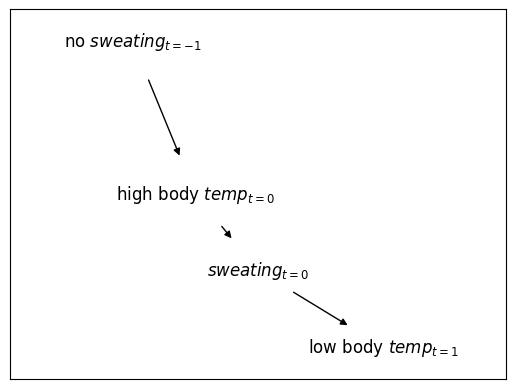

In [12]:
# create a directed graph
# https://medium.com/@whystudying/causal-inference-with-python-causal-graphs-ef2f3a52c266
plt.margins(x = 0.4)

G = nx.DiGraph()

# add edges from a list of tuples
G.add_edges_from([('no $sweating_{t=-1}$', 'high body $temp_{t=0}$'),\
                  ('high body $temp_{t=0}$', '$sweating_{t=0}$'),\
                  ('$sweating_{t=0}$', 'low body $temp_{t=1}$'),\
                 ])

# fix the positions of all three nodes
fixed_positions = {'no $sweating_{t=-1}$':(0,2),\
                   'high body $temp_{t=0}$':(0.5,1),\
                   '$sweating_{t=0}$':(1,0.5), \
                   'low body $temp_{t=1}$':(2,0)}

# draw the network
nx.draw_networkx(G,\
                 with_labels = True,\
                 node_color = 'white',\
                 node_size = 1000, \
                 pos = fixed_positions, min_source_margin = 30, min_target_margin = 30)

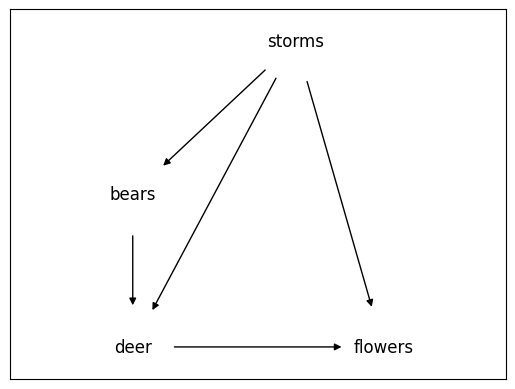

In [13]:
# https://medium.com/@whystudying/causal-inference-with-python-causal-graphs-ef2f3a52c266
plt.margins(x = 0.4)

G = nx.DiGraph()

# add edges from a list of tuples
G.add_edges_from([('storms', 'deer'),\
                  ('storms', 'bears'),\
                  ('storms', 'flowers'),\
                  ('bears', 'deer'),\
                  ('deer', 'flowers'),\
                 ])

# fix the positions of all nodes
fixed_positions = {'storms':(1.3,2),\
                   'bears':(0,1),\
                   'deer':(0,0), \
                   'flowers':(2,0)}

# draw the network
nx.draw_networkx(G,\
                 with_labels = True,\
                 node_color = 'white',\
                 node_size = 1000,\
                 pos = fixed_positions, min_source_margin = 30, min_target_margin = 30)

In [16]:
num = 10000
W_storms = np.random.normal(50, 10, num)
W_bears = 100 - 0.3 * W_storms + np.random.normal(0, 5, num)
X_deer = 150 - 0.5 * W_storms - W_bears + np.random.normal(0, 10, num)
Y_flowers = 20 + W_storms - 0.3 * X_deer + np.random.normal(0, 5, num)
df = pd.DataFrame({"W_storms": W_storms, "W_bears": W_bears, "X_deer": X_deer, "Y_flowers": Y_flowers})

df.corr()

,W_storms,W_bears,X_deer,Y_flowers
W_storms,1.000000,-0.520849,-0.174577,0.867395
W_bears,-0.520849,1.000000,-0.280714,-0.346383
X_deer,-0.174577,-0.280714,1.000000,-0.426784
Y_flowers,0.867395,-0.346383,-0.426784,1.000000


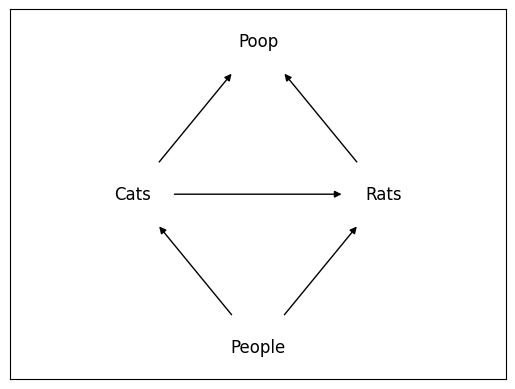

In [17]:
plt.margins(x = 0.4)

G = nx.DiGraph()

# add edges from a list of tuples
G.add_edges_from([('People', 'Cats'),\
                  ('People', 'Rats'),\
                  ('Cats', 'Rats'),\
                  ('Cats', 'Poop'),\
                  ('Rats', 'Poop'),\
                 ])

# fix the positions of all nodes
fixed_positions = {'Cats':(0, 0.5),\
                   'People':(0.5,0),\
                   'Poop':(0.5,1), \
                   'Rats':(1,0.5)}

# draw the network
nx.draw_networkx(G,\
                 with_labels = True,\
                 node_color = 'white',\
                 node_size = 1000,\
                 pos = fixed_positions, min_source_margin = 30, min_target_margin = 30)


### Week 6

In [22]:
num = 100000
Z_mean = 0.5
Z = np.random.normal(Z_mean, 1, num)
Z_prob = 1 / (1 + np.exp(Z))
X = np.random.binomial(1, Z_prob)
Y = 2 * X + Z + np.random.normal(0, 1, num)
df = pd.DataFrame({"X": X, "Y": Y, "Z": Z})

model = sm.OLS(df[['Y']], sm.add_constant(df[["X", "Z"]]))
results = model.fit()
results.params

treated = df[df.X == 1]
untreated = df[df.X == 0]

treated_cf = sm.add_constant(pd.DataFrame({"X": 0, "Z": treated["Z"]}), has_constant = "add")
treated_cf_prediction = results.predict(treated_cf)
untreated_cf = sm.add_constant(pd.DataFrame({"X": 1, "Z": untreated["Z"]}), has_constant = "add")
untreated_cf_prediction = results.predict(untreated_cf)

ites = untreated_cf_prediction.values - untreated.Y.values
perc_90 = np.percentile(ites, 90)
arg = np.where(ites == perc_90)


### Week 7

In [ ]:
# Question 1, regression not accounting for confounder
num = 10000
W = np.random.normal(0, 1, num)
X = 0.5 * W + np.random.normal(0, 1, num)
Y = W - 2 * X + np.random.normal(0, 1, num)

df = sm.add_constant(pd.DataFrame({"X": X}))
results = sm.OLS(Y, df).fit()
results.params

const   -0.001126
X       -1.605119
dtype: float64

In [27]:
# Question 2, regression where one coefficient is zero
pvals = []
for i in range(1000):
    num = 10000
    W = np.random.normal(0, 1, num)
    X = np.random.normal(0, 1, num)
    Y = 2 * X + np.random.normal(0, 1, num)

    df = sm.add_constant(pd.DataFrame({"X": X, "W": W}))
    results = sm.OLS(Y, df).fit()
    pvals.append(results.pvalues['W'])

print(min(pvals))

0.0012251526973226883


### Week 8

In [2]:
# Question 1 & 2
df_8_1 = pd.read_csv("/workspaces/DX702-mod-6/homework_8.1.csv")

# Estimate the propensity scores using logistic regression
# Use the model to predict the propensity scores
model = LogisticRegression()
model.fit(df_8_1[['Z']], df_8_1['X']) # predicting X from just Z
df_8_1['propensity_score'] = model.predict_proba(df_8_1[['Z']])[:, 1] # 0 and 1 are probabilities of false and of true

# Calculate the inverse probability weights
# 1/P for X=1, 1/(1-P) for X=0
df_8_1['ipw'] = (df_8_1.X == 1) * (1 / df_8_1['propensity_score']) + (df_8_1.X == 0) * (1 / (1 - df_8_1['propensity_score']))

# Estimate the average treatment effect
weighted_outcome_treated = np.sum(df_8_1.Y[df_8_1.X == 1] * df_8_1.ipw[df_8_1.X == 1]) / np.sum(df_8_1.ipw[df_8_1.X == 1])
weighted_outcome_untreated = np.sum(df_8_1.Y[df_8_1.X == 0] * df_8_1.ipw[df_8_1.X == 0]) / np.sum(df_8_1.ipw[df_8_1.X == 0])

# Average Treatment Effect
ate_ipw = weighted_outcome_treated - weighted_outcome_untreated
print(f"ATE using IPW: {ate_ipw}")

# 3 first propensity scores in dataframe
df_8_1.head(3)

ATE using IPW: 2.2743411898510133


,Unnamed: 0,X,Y,Z,propensity_score,ipw
0,0,1,4.109218,1.764052,0.840114,1.190315
1,1,0,2.259504,0.400157,0.584646,2.407585
2,2,0,-0.647584,0.978738,0.711082,3.461195


In [3]:
# Question 3 & 4
df_8_2 = pd.read_csv("/workspaces/DX702-mod-6/homework_8.2.csv")

# Use the Mahalanobis function from scipy.spatial.distance
from scipy.spatial.distance import mahalanobis

# Match all treated items to single nearest untreated using Mahalanobis distance w/replacement
# For the inverse covariance matrix pool Z1 and Z2 values into 2xN matrix
matrix = np.vstack((df_8_2.Z1, df_8_2.Z2))

# Find its covariance and invert
cov_matrix = np.cov(matrix)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Identify treated and untreated groups
treated = df_8_2[df_8_2['X'] == 1]
untreated = df_8_2[df_8_2['X'] == 0]

# Initiate NearestNeighbors model for matching using Mahalanobis
neighbors = NearestNeighbors(algorithm='brute', metric='mahalanobis', metric_params={'VI': inv_cov_matrix})

# Fit model to untreated items to match each treated item to an untreated one
neighbors.fit(untreated[['Z1','Z2']])

# Match treated samples to untreated (with replacement, which is default behavior for NearestNeighbors)
distances_treated_cf, indices_treated_cf = neighbors.kneighbors(treated[['Z1','Z2']], n_neighbors=1)

treated_cf = untreated.iloc[indices_treated_cf.ravel()].reset_index(drop = True)
treated_ = treated.reset_index(drop=True).copy()

ate_maha = treated_.Y.mean() - treated_cf.Y.mean()
print(f"ATE using Mahalanobis: {ate_maha}")

# Find covariates of item with greatest distance
indices = indices_treated_cf.reshape(indices_treated_cf.shape[0])
distances = distances_treated_cf.reshape(distances_treated_cf.shape[0])

treated['match_distance'] = distances
treated['matched_control_index'] = untreated.iloc[indices].index.values

treated_with_poor_support = treated.sort_values(by='match_distance', ascending=False)
print(treated_with_poor_support)


ATE using Mahalanobis: 3.4376789979126094
     Unnamed: 0  X         Y        Z1        Z2  match_distance  \
494         494  1  6.540236  2.696224  0.538155        1.383005   
898         898  1  5.623638  2.594425  2.893138        1.326817   
734         734  1  7.168479  2.497200  2.639007        1.164020   
54           54  1 -0.006131 -0.028182  3.142793        1.089164   
292         292  1  5.536318  2.303917  2.464578        1.053704   
..          ... ..       ...       ...       ...             ...   
182         182  1  3.627810 -0.643618 -0.944097        0.009414   
807         807  1  3.601438 -0.026192 -0.152762        0.009321   
785         785  1  3.864554  0.148450  0.483555        0.009301   
346         346  1  2.365336 -0.364694  0.115731        0.008420   
333         333  1  2.189725 -1.183881 -1.049968        0.005661   

     matched_control_index  
494                    418  
898                    161  
734                     85  
54                     24

/tmp/ipykernel_41580/3991378538.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treated['match_distance'] = distances
/tmp/ipykernel_41580/3991378538.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treated['matched_control_index'] = untreated.iloc[indices].index.values
